In [1]:
import torch
import numpy as np
import torch.nn.functional as F
import torch.nn as nn
from torch.utils.data import DataLoader
import sys

from itertools import cycle
from tqdm.auto import trange
from tqdm.notebook import tqdm

sys.path.append('../')
from matplotlib import cm
import matplotlib.pyplot as plt

from utils import plot as plot_utils, s3w as s3w_utils, vmf as vmf_utils
from utils.nf import normalizing_flows
from methods import s3wd as s3w, sswd as ssw, swd as sw

from scipy.stats import gaussian_kde

device = torch.device('cuda:1' if torch.cuda.is_available() else 'cpu')

In [2]:
mu_target = [0,1,0]
mu_target = mu_target / np.linalg.norm(mu_target)

kappa_target = 10

X_target = torch.tensor(vmf_utils.rand_vmf(mu_target, kappa=kappa_target, N=10000), dtype=torch.float)


In [3]:
def run_exp(X_target, X0, d_func, d_args, device, n_steps=2000, lr=0.1, batch_size=500):
    """
    Performs gradient flow on particles using a specified distance function.

    Args:
    - X_target (torch.Tensor): Target distribution tensor.
    - distance_fn (function): Distance function to be used.
    - distance_fn_args (dict): Arguments required for the distance function.
    - device (torch.device): Device to perform computations on.
    - n_steps (int): Number of gradient steps.
    - lr (float): Learning rate.
    - batch_size (int): Batch size for processing.

    Returns:
    - List of tensors representing the state of particles at each step.
    - List of loss values.
    """

    loader = DataLoader(X_target, batch_size=batch_size, shuffle=True)
    dataiter = cycle(loader)

    X0 = X0.to(device)
    X0.requires_grad_(True)

    optimizer = torch.optim.Adam([X0], lr=lr)

    L = [X0.clone()]
    L_loss = []

    pbar = trange(n_steps)

    for k in pbar:
        optimizer.zero_grad()
        X_batch = next(dataiter).type(torch.float).to(device)

        distance = d_func(X_batch, X0, **d_args)
        distance.backward()
        optimizer.step()

        X0.data /= torch.norm(X0.data, dim=1, keepdim=True)

        L_loss.append(distance.item())
        L.append(X0.clone().detach())
        pbar.set_postfix_str(f"Loss = {distance.item():.3f}")

    return L, L_loss

## Gradient Flow on Particles

In [4]:
X0 = torch.randn((500, 3), device=device)
X0 = F.normalize(X0, p=2, dim=-1)
d_func = s3w.ari_s3wd 
d_args = {'p': 2, 'n_projs': 100, 'device': device, 'n_rotations': 50}

L, L_loss1 = run_exp(X_target, X0, d_func , d_args, device, n_steps=1001, lr=1, batch_size=500)

  0%|          | 0/1001 [00:00<?, ?it/s]

In [5]:
X0 = torch.randn((500, 3), device=device)
X0 = F.normalize(X0, p=2, dim=-1)
d_func = s3w.ri_s3wd 
d_args = {'p': 2, 'n_projs': 100, 'device': device, 'n_rotations': 2}

L, L_loss2 = run_exp(X_target, X0, d_func , d_args, device, n_steps=1001, lr=1, batch_size=500)

  0%|          | 0/1001 [00:00<?, ?it/s]

In [6]:
X0 = torch.randn((500, 3), device=device)
X0 = F.normalize(X0, p=2, dim=-1)
d_func = s3w.ri_s3wd 
d_args = {'p': 2, 'n_projs': 100, 'device': device, 'n_rotations': 5}

L, L_loss5 = run_exp(X_target, X0, d_func , d_args, device, n_steps=1001, lr=1, batch_size=500)

  0%|          | 0/1001 [00:00<?, ?it/s]

In [7]:
X0 = torch.randn((500, 3), device=device)
X0 = F.normalize(X0, p=2, dim=-1)
d_func = s3w.ri_s3wd 
d_args = {'p': 2, 'n_projs': 100, 'device': device, 'n_rotations': 10}

L, L_loss10 = run_exp(X_target, X0, d_func , d_args, device, n_steps=1001, lr=1, batch_size=500)

  0%|          | 0/1001 [00:00<?, ?it/s]

In [8]:
X0 = torch.randn((500, 3), device=device)
X0 = F.normalize(X0, p=2, dim=-1)
d_func = s3w.ri_s3wd 
d_args = {'p': 2, 'n_projs': 100, 'device': device, 'n_rotations': 50}

L, L_loss50 = run_exp(X_target, X0, d_func , d_args, device, n_steps=1001, lr=1, batch_size=500)

  0%|          | 0/1001 [00:00<?, ?it/s]

In [9]:
X0 = torch.randn((500, 3), device=device)
X0 = F.normalize(X0, p=2, dim=-1)
d_func = s3w.ri_s3wd 
d_args = {'p': 2, 'n_projs': 100, 'device': device, 'n_rotations': 100}

L, L_loss100 = run_exp(X_target, X0, d_func , d_args, device, n_steps=1001, lr=1, batch_size=500)

  0%|          | 0/1001 [00:00<?, ?it/s]

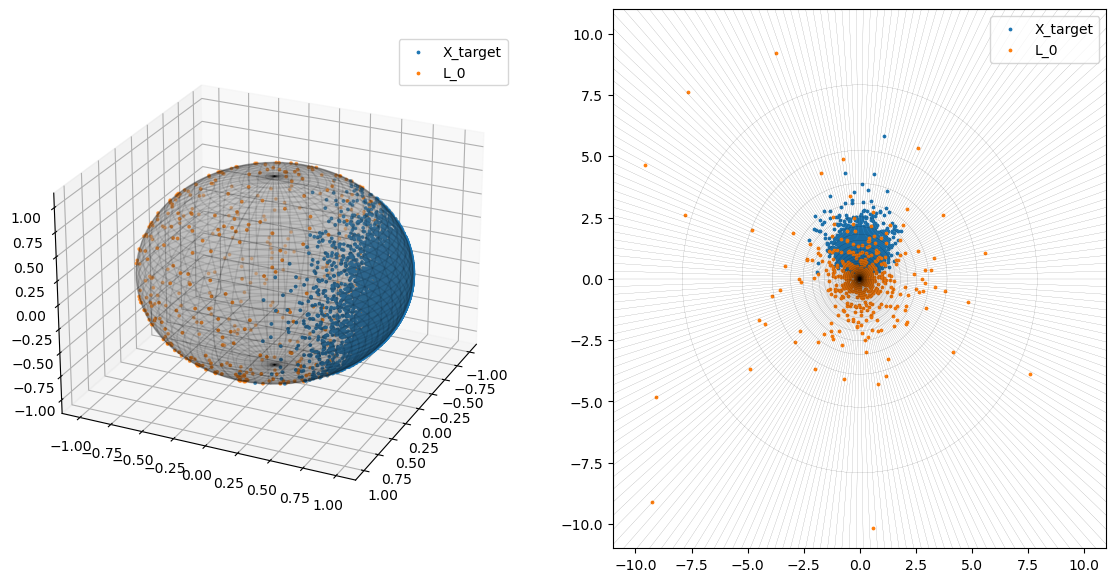

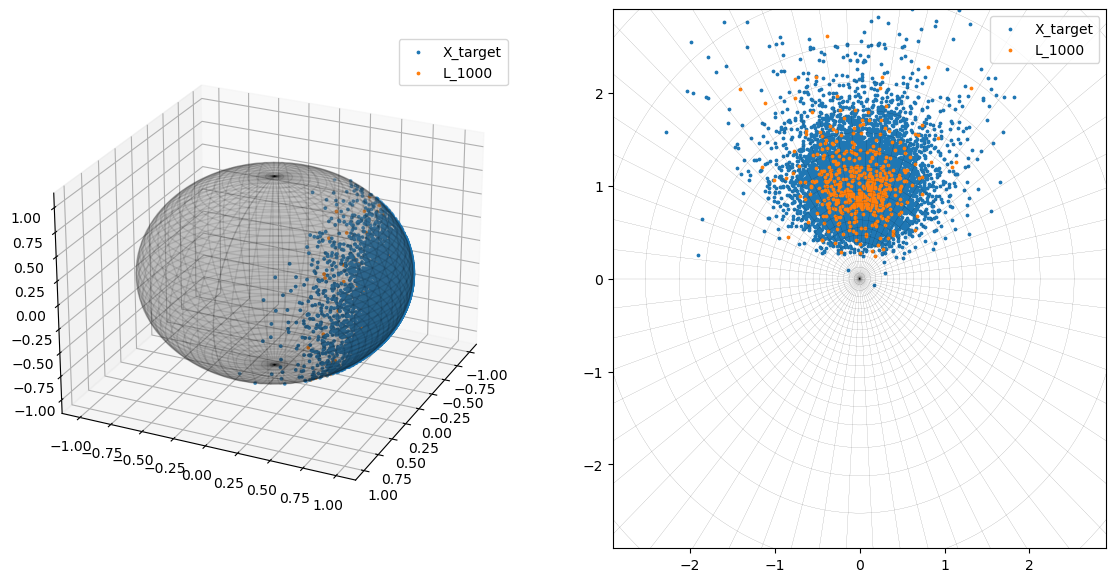

In [10]:
for k in [0, 1000]:
    X_target_cpu = X_target.cpu().detach().numpy()
    L_k_cpu = L[k].cpu().detach().numpy()

    datasets = [X_target_cpu, L_k_cpu]
    labels = ['X_target', f'L_{k}']

    plot_utils.plot_all(datasets, labels, view_init=(25, 25))

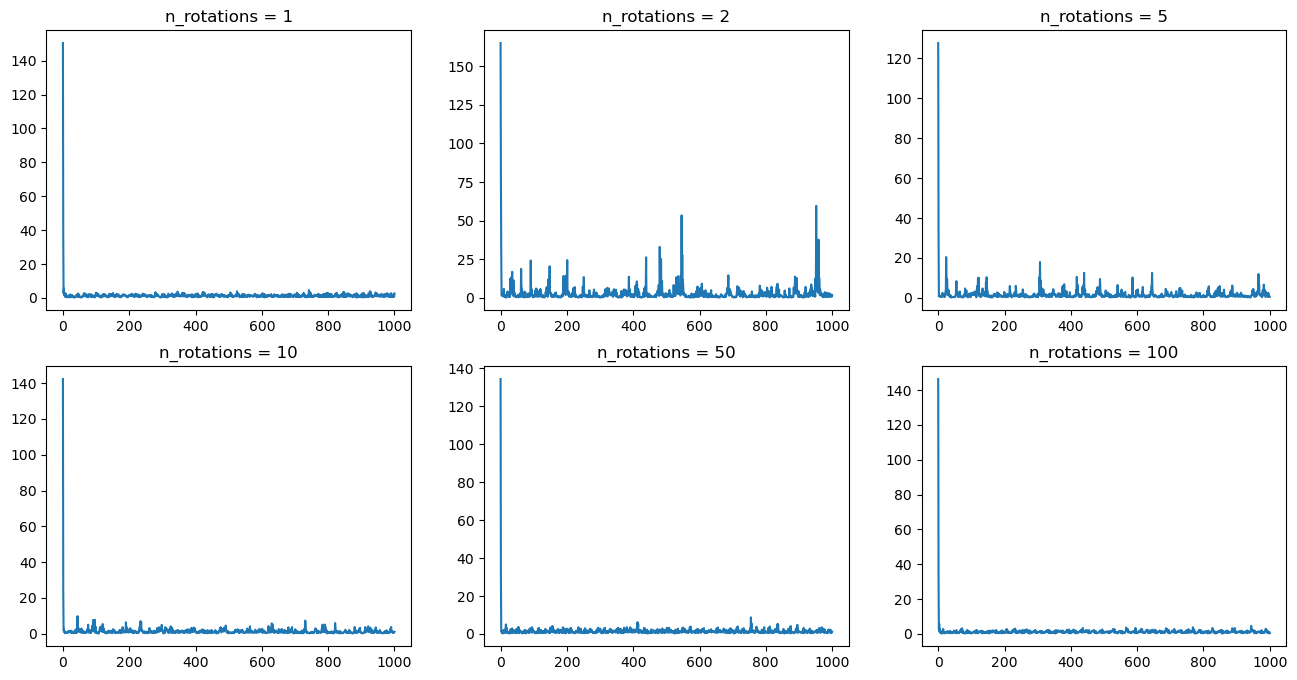

In [11]:
# Create plots of the 6 different loss curves
fig, ax = plt.subplots(2, 3, figsize=(16, 8))
ax[0, 0].plot(L_loss1)
ax[0, 0].set_title('n_rotations = 1')
ax[0, 1].plot(L_loss2)
ax[0, 1].set_title('n_rotations = 2')
ax[0, 2].plot(L_loss5)
ax[0, 2].set_title('n_rotations = 5')
ax[1, 0].plot(L_loss10)
ax[1, 0].set_title('n_rotations = 10')
ax[1, 1].plot(L_loss50)
ax[1, 1].set_title('n_rotations = 50')
ax[1, 2].plot(L_loss100)
ax[1, 2].set_title('n_rotations = 100')
plt.savefig('gf_loss_curves.png')
plt.show()